In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression

In [2]:
BACKGROUND = [0x20, 0x20, 0x20]
UNK_CHAR = "Ø"
HUE_COSINE_THRESHOLD = 0.9995
HASH_MAGIC = 1116 # https://www.youtube.com/watch?v=9iTPRwYguio
REF_HUE_CHANNEL = 0
REF_HUE_INTENSITY = 0xff # The ff in #fff4f0

# CRIB_NAME = "crib_minimap" # points to cribs/${CRIB_NAME}.py
# CRIB_NAME = "crib_one" # points to cribs/${CRIB_NAME}.py
CRIB_NAME = "crib_two" # points to cribs/${CRIB_NAME}.py

im.size=(90, 132)


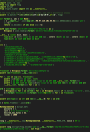

In [3]:
# !wget https://ctf.b6a.black/files/vs-code_141423313b894a2b059a23588ee4833a.png -O "vscode_original.png" -q
im = Image.open("vscode_original.png")
print(f"{im.size=}")
im

im_crib.size=(90, 4)
imdata.shape=(136, 90, 3)


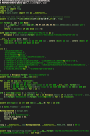

In [4]:
im_crib = Image.open("crib_minimap.png") 
print(f"{im_crib.size=}")
# bg #202020, fg #fff4f0
# Contents are ascii.printable across 2 lines with the leading "#"
# 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKL
# MNOPQRSTUVWXYZ!@#$%&'@@*+,-./:;<=>?@[]^_`{|}~

imdata = np.concatenate([np.array(im_crib), np.array(im)])
print(f"{imdata.shape=}")

Image.fromarray(imdata)

In [5]:
get_norm = lambda a: np.linalg.norm(a)
get_unit = lambda a: a / get_norm(a) if get_norm(a) != 0 else np.array([0, 0, 0])
clipbyte = lambda x: max(min(x, 255), 0)
rgb_to_hex = lambda a: "#" + "".join([f"{clipbyte(int(i)):02x}" for i in a])

class CipherCharacter:
    im_h, im_w, _ = imdata.shape
    cc_h, cc_w = im_h // 2, im_w # each character is 1w*2h

    # manual inspection is #202020
    bg_rgb = np.array(BACKGROUND)
    bg_rgbrgb = np.concatenate([bg_rgb, bg_rgb])

    def __init__(self, rgbrgb):
        # raw rgb data
        self.rgbrgb = np.array(rgbrgb)
        self.top, self.bot = self.rgbrgb[:3], self.rgbrgb[3:]

        # relative data, norms
        self.mean = (self.top + self.bot) / 2
        self.rel = self.mean - self.bg_rgb
        self.rel_n = get_norm(self.rel)
        self.rel_u = get_unit(self.rel)
        self.top_rel_n, self.bot_rel_n = get_norm(self.top - self.bg_rgb), get_norm(self.bot - self.bg_rgb)

        # positions / plaintext / top-bottom luminance
        self.pos = set()
        self.pln = None
        self.hue = None
        self.tblum = None

    def add_pos(self, x, y):
        # track position
        self.pos.add((x, y))

    def set_pln(self, pln):
        # set known plaintext
        self.pln = pln

    def set_hue(self, hue):
        self.hue = hue

    def set_tblum(self, tblum):
        self.tblum = tblum

    def hue_similarity(self, other):
        # cosine similarity using unit vectors of hue
        return np.dot(self.rel_u, other.rel_u)

    def __repr__(self):
        return f"CC({rgb_to_hex(self.top)}/{rgb_to_hex(self.bot)})"

    def __hash__(self):
        return hash(tuple(self.rgbrgb)) * HASH_MAGIC

    # singleton db
    rgbrgb_to_cc = {}
    xy_to_cc = {}

    @classmethod
    def from_pos(cls, x, y):
        # read from image
        # rgbrgb = im.getpixel((x, y * 2))[:3] + im.getpixel((x, y * 2 + 1))[:3]
        rgbrgb = tuple([int(i) for i in tuple(imdata[y*2][x]) + tuple(imdata[y*2+1][x])])

        if (rgbrgb == cls.bg_rgbrgb).all():
            return None
        if rgbrgb not in cls.rgbrgb_to_cc:
            cls.rgbrgb_to_cc[rgbrgb] = CipherCharacter(rgbrgb)

        cls.rgbrgb_to_cc[rgbrgb].add_pos(x, y)
        cls.xy_to_cc[(x, y)] = cls.rgbrgb_to_cc[rgbrgb]
        return cls.rgbrgb_to_cc[rgbrgb]

    @classmethod
    def from_rgbrgb(cls, rgbrgb):
        # query using rgbrgb
        return cls.rgbrgb_to_cc.get(rgbrgb, None)

    @classmethod
    def to_file(cls, name, ret="pln"): # or ret="hue" to output hue chunks
        # export to file
        lines = []
        unk_count = 0
        for y in range(cls.cc_h):
            line = []
            for x in range(cls.cc_w):
                cc = cls.from_pos(x, y)
                if cc is None:
                    line.append(" ")
                    continue
                
                if ret == "pln":
                    if cc.pln is None:
                        line.append(UNK_CHAR)
                        unk_count += 1
                    else:
                        line.append(cc.pln)
                elif ret == "hue":
                    if cc.hue is None:
                        line.append(UNK_CHAR)
                        unk_count += 1
                    else:
                        line.append(cc.hue.shortname)

            lines.append("".join(line).rstrip())
        lines = "\n".join(lines)
        with open(name, "w") as f:
            f.write(lines)
        print(f"Exported to {name}, has {unk_count} unknowns")

# Read all rgbrgb in image file
for y in range(CipherCharacter.cc_h):
    for x in range(CipherCharacter.cc_w):
        CipherCharacter.from_pos(x, y)
print(f"Found rgbrgb for {len(CipherCharacter.xy_to_cc)} characters")
print(f"Found {len(CipherCharacter.rgbrgb_to_cc)} unique rgbrgb")

Found rgbrgb for 2025 characters
Found 411 unique rgbrgb


  0%|          | 0/411 [00:00<?, ?it/s]

Palette with 20 hues
H(crib: 90,ref=CC(#a39d9a/#918b89),pln=)
H(regex: 14,ref=CC(#a0b393/#5a6354),pln=)
H(number: 10,ref=CC(#b0a676/#615d47),pln=)
H(system: 16,ref=CC(#aebb47/#606632),pln=)
H(kwarg: 21,ref=CC(#697053/#848e66),pln=)
H(flow: 16,ref=CC(#627d28/#6b8a29),pln=)
H(builtin: 20,ref=CC(#407a2d/#45882e),pln=)
H(escape:  6,ref=CC(#597a17/#547317),pln=)
H(symbol:  4,ref=CC(#6f6f58/#525243),pln=)
H(string2: 13,ref=CC(#0f970f/#147014),pln=)
H(rawstring: 11,ref=CC(#649044/#3f5331),pln=)
H(argument: 15,ref=CC(#607d1f/#4b5f20),pln=)
H(datatype: 15,ref=CC(#367e1d/#2f601e),pln=)
H(variable: 43,ref=CC(#4e794e/#2f3c2f),pln=)
H(fndef: 10,ref=CC(#25750a/#224b15),pln=)
H(string1: 81,ref=CC(#176e17/#1c461c),pln=)
H(comments1: 19,ref=CC(#273623/#2a3f25),pln=)
H(comments2:  5,ref=CC(#283724/#263123),pln=)
H(comments3:  1,ref=CC(#253123/#222821),pln=)
H(comments4:  1,ref=CC(#202020/#232a22),pln=)
Exported to outputs/hue_clusters.py, has 0 unknowns


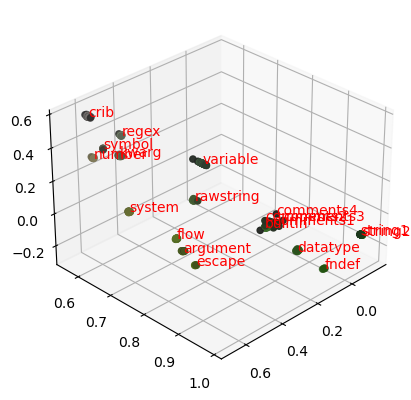

In [6]:
class Hue:
    def __init__(self, name, shortname, ref_cc):
        self.name = name
        self.shortname = shortname
        self.ref_cc = ref_cc
        self.ccs = set()

        self.add_cc(ref_cc)
        self.plnmap = None
    
    def hue_similarity(self, other):
        return self.ref_cc.hue_similarity(other)

    def add_cc(self, cc):
        self.ccs.add(cc)
        cc.set_hue(self)
    
    def plnset(self):
        plnset = [
            cc.pln
            for cc in self.ccs
            if cc.pln is not None
        ]
        return "".join(sorted(plnset))

    def update_plnmap(self):
        self.plnmap = {
            cc.pln: cc
            for cc in self.ccs
            if cc.pln is not None
        }

    def __repr__(self):
        return f"H({self.name}: {len(self.ccs):2},ref={self.ref_cc},pln={self.plnset()})"

class Palette:
    # post-hoc from analysing output/hue_clusters.py with HUE_COSINE_THRESHOLD=0.9995
    hue_names = [
        ("A", "crib"),
        ("B", "regex"),
        ("C", "number"),
        ("D", "system"),
        ("E", "kwarg"),
        ("F", "flow"),
        ("G", "builtin"),
        ("H", "escape"),
        ("I", "symbol"),
        ("J", "string2"),
        ("K", "rawstring"),
        ("L", "argument"),
        ("M", "datatype"),
        ("N", "variable"),
        ("O", "fndef"),
        ("P", "string1"),
        ("Q", "comments1"),
        ("R", "comments2"),
        ("S", "comments3"),
        ("T", "comments4"),
    ]
    crib_hue_name = hue_names[0][1]

    def __init__(self):
        self.hues = {}
    
    def best_hue(self, cc):
        if len(self.hues) == 0:
            return -1, None
        # return hue with best cosine similarity
        # author's soln considers a dynamic error margin to compensate
        # for rounding error, that is likely more robust
        similarity_scores = [
            (hue.hue_similarity(cc), hue.name)
            for hue in self.hues.values()
        ]
        similarity_scores.sort()
        return similarity_scores[-1]

    def process_cc(self, cc):
        best_hue_score, best_hue_name = self.best_hue(cc)
        if best_hue_score >= HUE_COSINE_THRESHOLD: # 0.9995, determined by guessing
            # if good hue matches current char, add to other hue
            self.hues[best_hue_name].add_cc(cc)
        else:
            # no good hue, start a new cluster
            new_hue_shortname, new_hue_name = self.hue_names[len(self.hues)]
            self.hues[new_hue_name] = Hue(new_hue_name, new_hue_shortname, cc)

    def show(self):
        print(f"Palette with {len(self.hues)} hues")
        for hues in self.hues.values():
            print(hues)

    def show_3d(self):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        xs, ys, zs, cs = [], [], [], []

        for hue in self.hues.values():
            ax.text(*list(hue.ref_cc.rel_u), hue.name, color='red')
            for cc in hue.ccs:
                xs.append(cc.rel_u[0])
                ys.append(cc.rel_u[1])
                zs.append(cc.rel_u[2])
                cs.append(rgb_to_hex(cc.mean))
        ax.scatter(xs, ys, zs, c=cs)
        ax.view_init(elev=30, azim=45, roll=0)

    def predict_colors(self):
        # from crib_minimap.png
        ref_hue = self.hues[Palette.crib_hue_name]
        ref_hue.update_plnmap()
        colormap = {}

        # for each hue
        for hue in self.hues.values():
            hue_rgb = []
            error_scores = []
            # for each channel
            for channel_i in range(3):
                # linreg x = crib char intensity, y =  this hue char intensity
                # then find y when x=REF_HUE_INTENSITY to get font color
                xs, ys = [], []

                # for each pln
                for cc in hue.ccs:
                    if cc.pln is None:
                        continue
                    rcc = ref_hue.plnmap.get(cc.pln)
                    if rcc is None:
                        continue
                    for px, rpx in [(cc.top, rcc.top), (cc.bot, rcc.bot)]:
                        xs.append(rpx[REF_HUE_CHANNEL])
                        ys.append(px[channel_i])

                linreg = LinearRegression()
                linreg.fit(np.array(xs).reshape((-1, 1)), np.array(ys))
                error_score = linreg.score(np.array(xs).reshape((-1, 1)), np.array(ys))
                intensity = linreg.predict([[REF_HUE_INTENSITY]])[0]

                hue_rgb.append(round(intensity))
                error_scores.append(f"{error_score:.3f}")
            hue_rgb_hex = rgb_to_hex(hue_rgb)
            print(f"Recovered color {hue_rgb_hex} for {hue.name:10} confidence {' / '.join(error_scores)}")

assert len([i[0] for i in Palette.hue_names]) == len(set([i[0] for i in Palette.hue_names]))
assert len([i[1] for i in Palette.hue_names]) == len(set([i[1] for i in Palette.hue_names]))

# Cluster colors
cc_by_intensity = list(CipherCharacter.rgbrgb_to_cc.values())
cc_by_intensity.sort(key=lambda cc: cc.rel_n, reverse=True)
palette = Palette()
for cc in tqdm(cc_by_intensity):
    palette.process_cc(cc)
palette.show()
palette.show_3d()
CipherCharacter.to_file(f"outputs/hue_clusters.py", ret="hue")

In [7]:
with open(f"cribs/{CRIB_NAME}.py", "r") as f:
    crib_lines = f.read().split("\n")

# reset any previous pln in case this cell is re-run
for cc in CipherCharacter.rgbrgb_to_cc.values():
    cc.set_pln(None)

for y, crib_line in enumerate(crib_lines):
    for x, crib_char in enumerate(crib_line):
        cc = CipherCharacter.from_pos(x, y)
        if cc is None:
            assert crib_char == " "
            continue
        
        if crib_char == UNK_CHAR:
            # unknown character in crib
            continue
        if cc.pln is not None and crib_char != cc.pln:
            print(f"Warning: conflicting crib char expected {cc.pln} now {crib_char} at xy=({x},{y})")
            continue
        # known character in crib, replace all instances of this top/bottom color with newly found character
        cc.set_pln(crib_char)

!mkdir -p outputs
CipherCharacter.to_file(f"outputs/{CRIB_NAME}_naive.py")

palette.show()

Exported to outputs/crib_two_naive.py, has 46 unknowns
Palette with 20 hues
H(crib: 90,ref=CC(#a39d9a/#918b89),pln=!#$%&'*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~)
H(regex: 14,ref=CC(#a0b393/#5a6354),pln=$-09AZ^_acftz)
H(number: 10,ref=CC(#b0a676/#615d47),pln=0123456789)
H(system: 16,ref=CC(#aebb47/#606632),pln=EINdeilmnopst)
H(kwarg: 21,ref=CC(#697053/#848e66),pln=_abcdegiklnoprstuwxyz)
H(flow: 16,ref=CC(#627d28/#6b8a29),pln=adefhilmnoprstuw)
H(builtin: 20,ref=CC(#407a2d/#45882e),pln=_`abcdefhilmnopqrstz)
H(escape:  6,ref=CC(#597a17/#547317),pln=%+[]ao)
H(symbol:  4,ref=CC(#6f6f58/#525243),pln=-:=)
H(string2: 13,ref=CC(#0f970f/#147014),pln=)@C`adinorst)
H(rawstring: 11,ref=CC(#649044/#3f5331),pln=012346\ux{)
H(argument: 15,ref=CC(#607d1f/#4b5f20),pln=_acdefklmorstuw)
H(datatype: 15,ref=CC(#367e1d/#2f601e),pln=bcdefilnoprstyz)
H(variable: 43,ref=CC(#4e794e/#2f3c2f),pln=(),.58:ACDEMORST[]_abcdefghijklmnoprstuwxyz)
H(fndef: 10,ref=CC(#25750a/#22

Aligning hue crib       with align_val=1.00000, fixed


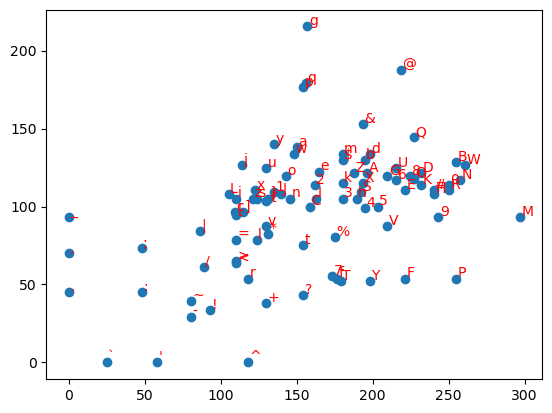

In [8]:
class Alignment:
    def __init__(self):
        # pln_to_tblum[character] = (top luminance, bottom luminance)
        self.pln_to_tblum = {}
    
    def save_tblum(self, cc):
        # save top-bottom luminance for future lookup
        if cc.pln in self.pln_to_tblum:
            return
        self.pln_to_tblum[cc.pln] = cc.tblum
    
    def best_pln_for_tblum(self, tblum):
        # try all possible pln, return the pln with closest tblum with its l2 error
        twblum_fitness = [
            (get_norm(pln_tblum - tblum), pln)
            for pln, pln_tblum in self.pln_to_tblum.items()
        ]
        twblum_fitness.sort()
        return twblum_fitness[0]

    def align_hue(self, hue, align_val):
        # alignment has been chosen, save
        for cc in hue.ccs:
            tblum = np.array([
                cc.top_rel_n * align_val,
                cc.bot_rel_n * align_val
            ])
            cc.set_tblum(tblum)
            
            self.save_tblum(cc)
            if cc.pln is None:
                continue

    def align_hue_one(self, hue):
        # align one hue with "1.0" brightness
        align_val = 1
        print(f"Aligning hue {hue.name:10} with {align_val=:.5f}, fixed")
        self.align_hue(hue, align_val)
    
    def error_if_aligned_with(self, hue, align_val):
        # total l2 error if this hue is aligned with this brightness
        total_error = 0
        for cc in hue.ccs:
            tblum = np.array([
                cc.top_rel_n * align_val,
                cc.bot_rel_n * align_val
            ])
            error, _ = self.best_pln_for_tblum(tblum)
            total_error += error
        return total_error / len(hue.ccs)

    def align_hue_search(self, hue, init_align_val=4, space=[4, 1, 0.01]):
        # iterated brute force search for best align_val
        align_val = init_align_val
        
        print(f"For hue {hue.name:10}: ", end="")
        for space_i in space:
            print(f"{align_val:.5f} +/- {space_i:} ... ", end="")
            error_scores = [
                (self.error_if_aligned_with(hue, align_val), align_val)
                for align_val in np.linspace(align_val - space_i, align_val + space_i, 300)
            ]
            error_scores.sort()
            align_val = error_scores[0][1]
        print()
        print(f"Aligning hue {hue.name:10} with {align_val=:.5f}, error score {error_scores[0][0]:.4f}")
        self.align_hue(hue, align_val)

    def recover_pln_from_tblums(self, hue, err_max=1):
        n_recovered = 0
        for cc in hue.ccs:
            if cc.pln is not None or cc.tblum is None:
                continue
            err, pln = self.best_pln_for_tblum(cc.tblum)
            if err <= err_max:
                cc.set_pln(pln)
                n_recovered += 1
        return n_recovered

    def show(self):
        fig = plt.figure()
        ax = fig.add_subplot()

        xs, ys = [], []
        for pln, tblum in self.pln_to_tblum.items():
            xs.append(tblum[0])
            ys.append(tblum[1])
            ax.text(tblum[0] + 1, tblum[1] + 1, pln, color='red')
        ax.scatter(xs, ys)

alignment = Alignment()
alignment.align_hue_one(palette.hues[Palette.crib_hue_name])
alignment.show()

In [9]:
for hue_name in tqdm(palette.hues):
    if hue_name == Palette.crib_hue_name:
        continue
    alignment.align_hue_search(palette.hues[hue_name])

  0%|          | 0/20 [00:00<?, ?it/s]

For hue regex     : 4.00000 +/- 4 ... 1.09699 +/- 1 ... 1.10702 +/- 0.01 ... 
Aligning hue regex      with align_val=1.10666, error score 0.5629
For hue number    : 4.00000 +/- 4 ... 1.17726 +/- 1 ... 1.16722 +/- 0.01 ... 
Aligning hue number     with align_val=1.16766, error score 0.5368
For hue system    : 4.00000 +/- 4 ... 1.20401 +/- 1 ... 1.20736 +/- 0.01 ... 
Aligning hue system     with align_val=1.20632, error score 0.3845
For hue kwarg     : 4.00000 +/- 4 ... 1.31104 +/- 1 ... 1.31438 +/- 0.01 ... 
Aligning hue kwarg      with align_val=1.31268, error score 0.5508
For hue flow      : 4.00000 +/- 4 ... 1.36455 +/- 1 ... 1.35452 +/- 0.01 ... 
Aligning hue flow       with align_val=1.35542, error score 0.3899
For hue builtin   : 4.00000 +/- 4 ... 1.60535 +/- 1 ... 1.61538 +/- 0.01 ... 
Aligning hue builtin    with align_val=1.61381, error score 1.1341
For hue escape    : 4.00000 +/- 4 ... 1.41806 +/- 1 ... 1.41472 +/- 0.01 ... 
Aligning hue escape     with align_val=1.41341, erro

In [10]:
for threshold in [1, 100]:
    n_recovered = 0
    for hue_name in tqdm(palette.hues):
        n_recovered += alignment.recover_pln_from_tblums(palette.hues[hue_name], threshold)
    print(f"Recovered {n_recovered} pln using alignment with {threshold=}")
    CipherCharacter.to_file(f"outputs/{CRIB_NAME}_align_{threshold}.py")

palette.show()

  0%|          | 0/20 [00:00<?, ?it/s]

Recovered 9 pln using alignment with threshold=1
Exported to outputs/crib_two_align_1.py, has 33 unknowns


  0%|          | 0/20 [00:00<?, ?it/s]

Recovered 12 pln using alignment with threshold=100
Exported to outputs/crib_two_align_100.py, has 2 unknowns
Palette with 20 hues
H(crib: 90,ref=CC(#a39d9a/#918b89),pln=!#$%&'*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~)
H(regex: 14,ref=CC(#a0b393/#5a6354),pln=$-09AZ^_acftz)
H(number: 10,ref=CC(#b0a676/#615d47),pln=0123456789)
H(system: 16,ref=CC(#aebb47/#606632),pln=EINTdeilmnoprstu)
H(kwarg: 21,ref=CC(#697053/#848e66),pln=_abcdegiklnoprstuwxyz)
H(flow: 16,ref=CC(#627d28/#6b8a29),pln=adefhilmnoprstuw)
H(builtin: 20,ref=CC(#407a2d/#45882e),pln=_`abcdefhilmnopqrstz)
H(escape:  6,ref=CC(#597a17/#547317),pln=%+[]ao)
H(symbol:  4,ref=CC(#6f6f58/#525243),pln=*-:=)
H(string2: 13,ref=CC(#0f970f/#147014),pln=).@C`adinorst)
H(rawstring: 11,ref=CC(#649044/#3f5331),pln=012346\ux{})
H(argument: 15,ref=CC(#607d1f/#4b5f20),pln=_acdefklmorstuw)
H(datatype: 15,ref=CC(#367e1d/#2f601e),pln=bcdefilnoprstyz)
H(variable: 43,ref=CC(#4e794e/#2f3c2f),pln=(),.58:ACDEMOR

In [11]:
palette.predict_colors()

Recovered color #fff4f0 for crib       confidence 1.000 / 1.000 / 1.000
Recovered color #defaca for regex      confidence 1.000 / 1.000 / 1.000
Recovered color #f5e6a0 for number     confidence 1.000 / 1.000 / 1.000
Recovered color #ebff58 for system     confidence 1.000 / 1.000 / 0.999
Recovered color #ccde99 for kwarg      confidence 1.000 / 1.000 / 0.999
Recovered color #beff33 for flow       confidence 1.000 / 1.000 / 0.977
Recovered color #6df83e for builtin    confidence 0.998 / 0.999 / 0.992
Recovered color #adfd08 for escape     confidence 1.000 / 1.000 / 0.990
Recovered color #ffffbf for symbol     confidence 1.000 / 1.000 / 1.000
Recovered color #09c809 for string2    confidence 0.569 / 0.657 / 0.569
Recovered color #85c656 for rawstring  confidence 1.000 / 1.000 / 0.998
Recovered color #98cf20 for argument   confidence 1.000 / 1.000 / 0.115
Recovered color #49d01b for datatype   confidence 0.993 / 1.000 / 0.713
Recovered color #5a8f5a for variable   confidence 0.999 / 1.000 